# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR.

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [6]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    # request the data from the data url
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return None

In [7]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

### 2. Transform the data into a usable shape and format


In [8]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [9]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [29]:
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [25]:
# 50'000 Rows / 3'072 Observations (32*32*3)
dataset_train[b'data'].shape

(50000, 3072)

In [26]:
dataset_meta.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

In [28]:
for label in dataset_meta.keys():
    print(label, ":\n", dataset_meta[label])
    print("Count:", len(dataset_meta[label]))

b'fine_label_names' :
 [b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'road', b'rocket', b'rose', b'sea', b'seal', b'shark', b'shrew', b'skunk', b'skyscraper', b'snail', b'snake', b'spider', b'squirrel', b'streetcar', b'sunflower', b'sweet_pepper', b'table', b'tank', b'telephon

In [30]:
dataset_test.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [31]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [32]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [33]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

In [34]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [35]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [36]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [37]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


In [38]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [39]:
plt.imsave("file.png", test_image)

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [42]:
import pandas as pd

# Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles
for  i, label in enumerate(dataset_meta[b'fine_label_names']):
    if label  in [b'bicycle',b'motorcycle']:
        print( f"Label -  {label},  Number: {i}")


Label -  b'bicycle',  Number: 8
Label -  b'motorcycle',  Number: 48


Safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [44]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[(df_train['labels'] == 8) | (df_train['labels'] == 48)]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[(df_test['labels'] == 8) | (df_test['labels'] == 48)]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

In [45]:
df_train.head()

,filenames,labels,row
16,bike_s_000682.png,8,16
30,bike_s_000127.png,8,30
130,cycle_s_002598.png,8,130
152,minibike_s_000824.png,48,152
195,motorcycle_s_001856.png,48,195


Now that the data is filtered for just our classes, we can save all our images.

In [46]:
!mkdir ./train
!mkdir ./test


Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [49]:
import os

def save_images(selected_images_df, initial_dataset, filepath):
    
    rows = selected_images_df['row']
    
    filenames = selected_images_df['filenames']
    
    for row, filename in zip(rows, filenames):
        img = initial_dataset[b'data'][row]
        
        target = np.dstack((
                        img[0:1024].reshape(32,32,1),
                        img[1024:2048].reshape(32,32,1),
                        img[2048:].reshape(32,32,1)
                         ))
        
        saved_img_path = os.path.join(filepath, filename)
        
        plt.imsave(saved_img_path, target)
        


In [50]:
## Save ALL images using the save_images function
save_images(df_train, dataset_train, './train')

In [51]:
save_images(df_test, dataset_test, './test')

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [ ]:
import sagemaker

session = sagemaker.Session()


bucket= session.default_bucket()
# print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
# print("RoleArn: {}".format(role))

With this data we can easily sync your data up into S3!

In [ ]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [56]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [57]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [59]:
# Using image_uris function to retrieve the latest 'image-classification' image 
algo_image = sagemaker.image_uris.retrieve(region=region, framework='image-classification')
s3_output_location = f"s3://{bucket}/models/image_model"

We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`.

In [60]:
img_classifier_model=sagemaker.estimator.Estimator(
    algo_image, 
    role=role, 
    instance_count=1, 
    instance_type='ml.p3.2xlarge', 
    volume_size=30, 
    max_run=60*30, 
    input_mode='File',
    output_path=s3_output_location, 
    sagemaker_session=session,
)

We can also set a few key hyperparameters and define the inputs for our model:

In [64]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32',
    num_classes=2,
    num_training_samples=len(df_train) ,
)

The `image-classification` image uses four input channels with very specific input parameters.

In [65]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [ ]:
img_classifier_model.fit(model_inputs)


### Getting ready to deploy

To begin with, configure Model Monitor to track our deployment. 

In [68]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True, 
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

In [70]:
deployment = img_classifier_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2023-04-01-12-15-33-248
INFO:sagemaker:Creating endpoint-config with name image-classification-2023-04-01-12-15-33-248
INFO:sagemaker:Creating endpoint with name image-classification-2023-04-01-12-15-33-248


--------!image-classification-2023-04-01-12-15-33-248


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [71]:
from sagemaker.predictor import Predictor

predictor = Predictor(endpoint)

Use the predictor to process the `payload`.

In [72]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload, initial_args={'ContentType': 'application/x-image'})

The `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of beingpredictorike is 91% and being a motorcycle is 9%.

In [73]:
print(inference)

b'[0.9999779462814331, 2.206077624578029e-05]'


Now I can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation


Here's a function that can help you generate test inputs for your invokations:

In [ ]:
import random
import boto3
import json


def generate_test_case():
    
    s3 = boto3.resource('s3')
    

    objects = s3.Bucket(bucket).objects.filter(Prefix="test")
    

    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
generate_test_case()

In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.


In [ ]:
from sagemaker.s3 import S3Downloader

# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_path =   "s3://sagemaker-us-east-1-************/data_capture/image-classification-2023-04-01-12-15-33-248/AllTraffic/2023/04/01/15/"

S3Downloader.download(data_path, "captured_data")



The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [86]:
!pip install jsonlines
import jsonlines

Now we can extract the data from each of the source files:

In [88]:
import os


file_handles = os.listdir("./captured_data")


json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [89]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.07208187878131866, 0.9279181361198425], '2023-04-01T15:48:07Z')

Finally, here's an example of a visualization you can build with this data. 

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


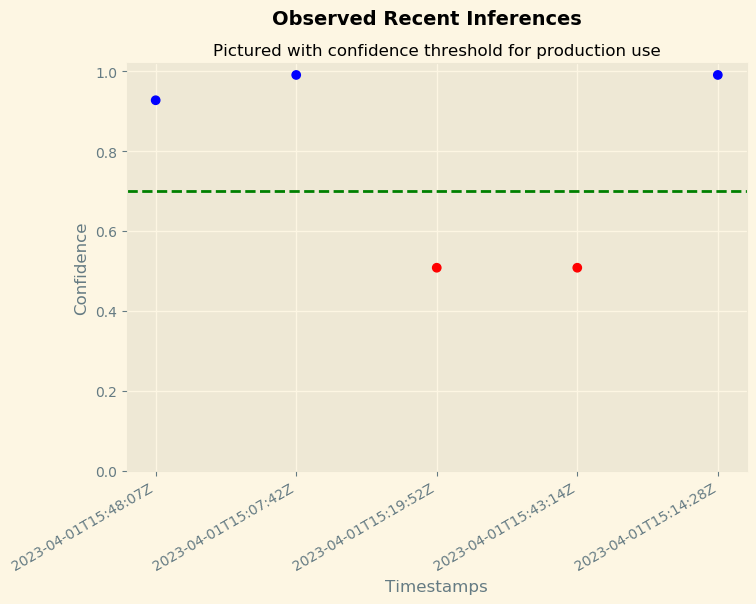

In [93]:
# Populate the data for the x and y axis
%matplotlib inline
THRESHOLD = 0.70
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data

plt.figure(figsize=(8,6))
plt.scatter(x, y, c=['r' if k<THRESHOLD else 'b' for k in y ])
plt.axhline(y=THRESHOLD, color='g', linestyle='--')
plt.ylim(bottom=0,top=1.02)

# Add labels
plt.ylabel("Confidence")
plt.xlabel("Timestamps")
plt.suptitle("Observed Recent Inferences", size=14, y=0.97, fontweight='bold')
plt.title("Pictured with confidence threshold for production use", size=12)


plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()
plt.show()

### Visualisation


In [97]:
def my_simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    images = obj["captureData"]["endpointInput"]["data"]
    return json.loads(inferences), timestamp, images

simple_getter(json_data[0])

([0.07208187878131866, 0.9279181361198425], '2023-04-01T15:48:07Z')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


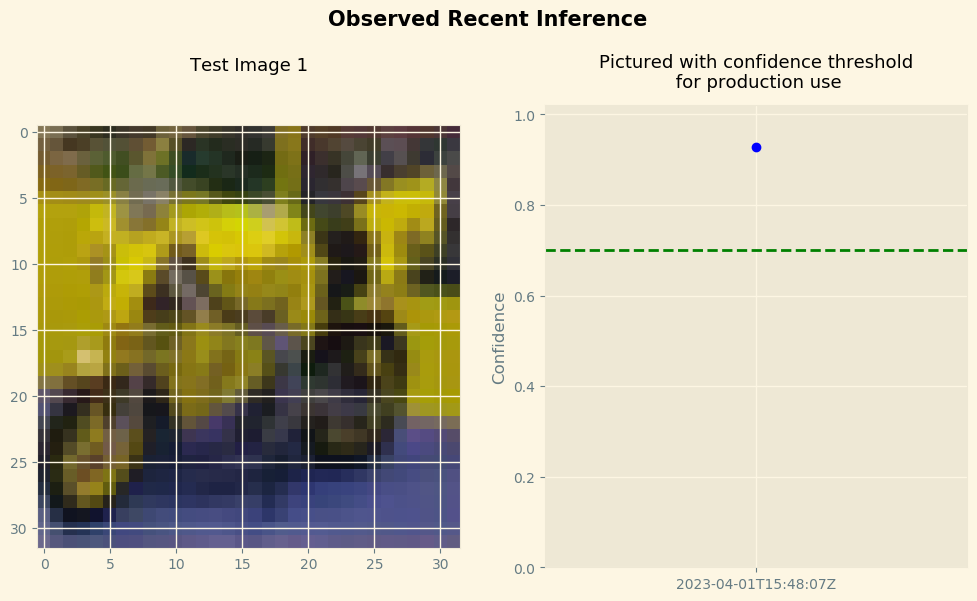

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


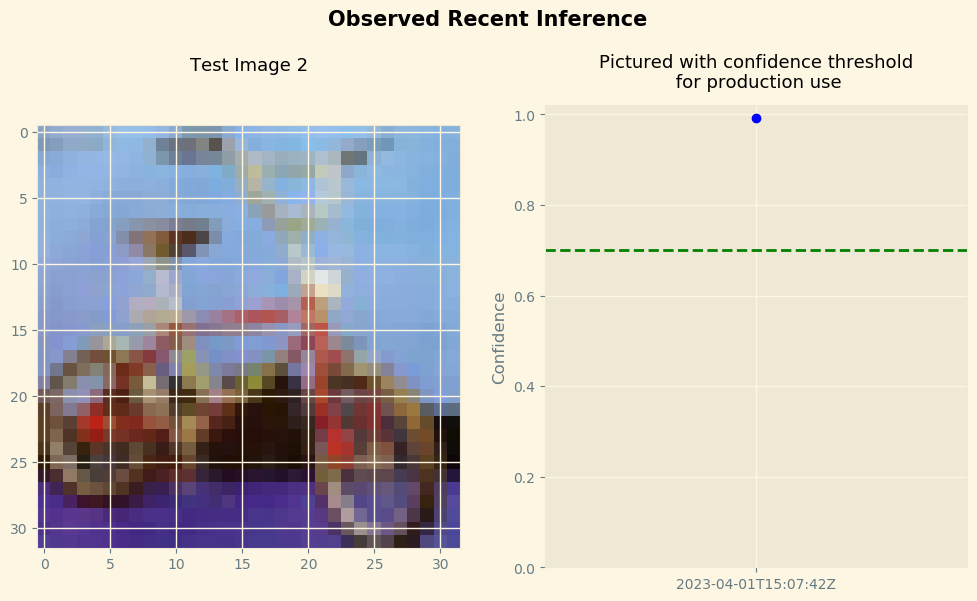

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


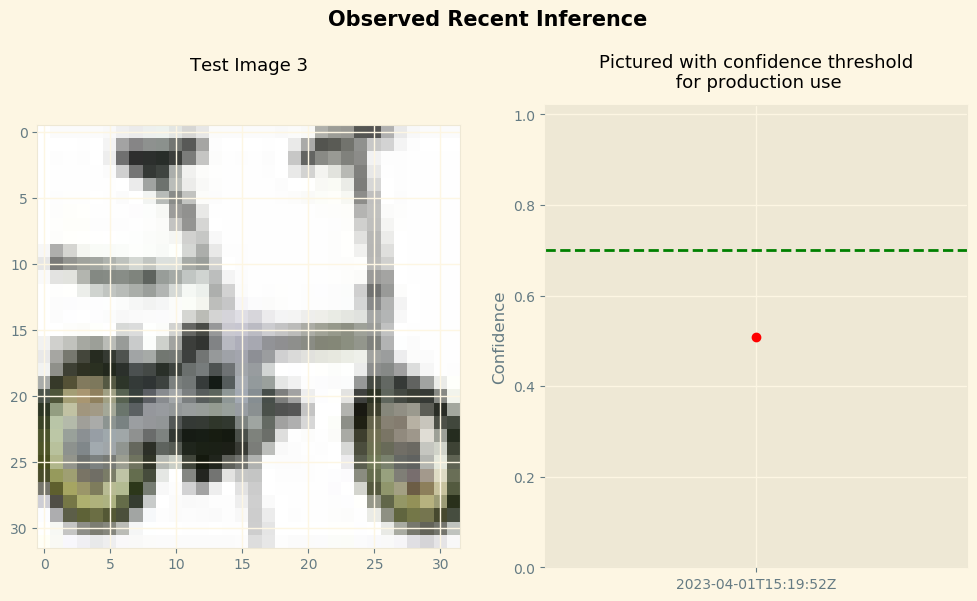

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


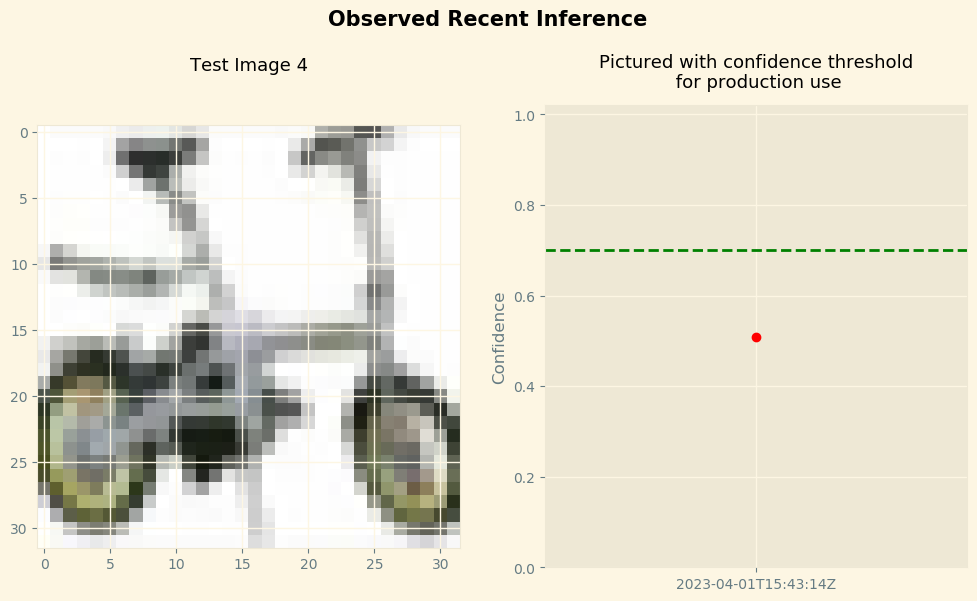

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


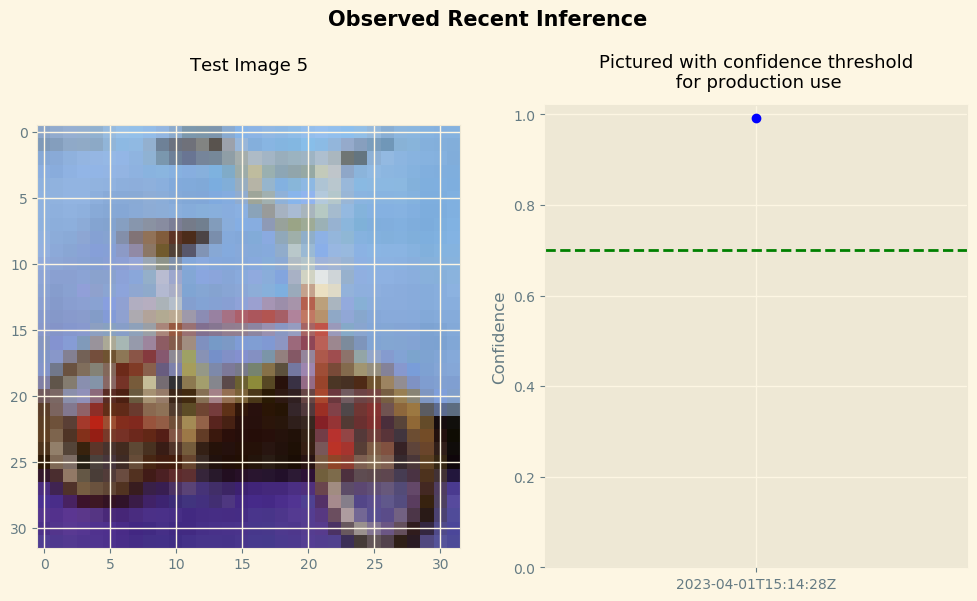

In [100]:
%matplotlib inline
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

x = []
y = []
for idx, obj in enumerate(json_data):
    inference, timestamp, image = my_simple_getter(obj)
    img = base64.b64decode(image)  
    img = io.BytesIO(img) 
    img = Image.open(img)       
    

    f = plt.figure(figsize=(12, 6))

    f.suptitle("Observed Recent Inference", size=15, y=1.04, fontweight='bold')
    
    

    ax1 = f.add_subplot(121)
    ax1.set_title(f"Test Image {idx+1}", size=13, y=1.11)
    ax1.imshow(img, interpolation='nearest')
    
    

    ax2 = f.add_subplot(122)
    ax2.scatter(timestamp, max(inference), c=['r' if max(inference)<THRESHOLD else 'b'])
    ax2.axhline(y=THRESHOLD, color='g', linestyle='--')
    ax2.set_ylim(bottom=0,top=1.02)
    # Add labels
    ax2.set_ylabel("Confidence")
    ax2.set_title("Pictured with confidence threshold\n for production use", size=13, y=1.02)
    
    plt.show()
